In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [2]:
dataset = pd.read_csv("../../datasets/toxic_comments_1.csv",nrows=6000)

In [3]:
dataset = dataset[["comment_text","toxic"]]

In [4]:
#cleaning the text
dataset.columns = ["comment","toxic"]
dataset["comment"] = dataset["comment"].str.replace("\n"," ")

In [5]:
bag_of_words = []
import re
for i in range(0,6000):
    words = re.sub('[^a-zA-Z]',' ',dataset["comment"][i])
    words = words.lower().split()
    words = [word for word in words if not word in set(stopwords.words("english"))]
    sentence = ' '.join(words)
    bag_of_words.append(sentence)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Embedding

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(np.array(bag_of_words))


In [8]:
from tensorflow.keras.preprocessing import sequence
X = tokenizer.texts_to_sequences(np.array(bag_of_words))
X = sequence.pad_sequences(X,maxlen=50)

In [10]:
y = dataset["toxic"].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [11]:
from tensorflow.keras.layers import Embedding
model = Sequential()
model.add(Embedding(20000,50))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          1000000   
_________________________________________________________________
dense (Dense)                (None, None, 50)          2550      
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           51        
Total params: 1,002,601
Trainable params: 1,002,601
Non-trainable params: 0
_________________________________________________________________


In [12]:
#functions to calculate recall,precision and f1_score
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy',f1_m,precision_m, recall_m])

In [13]:
history = model.fit(X_train,y_train,batch_size=50,epochs=8,verbose=2)

Train on 4800 samples
Epoch 1/8
4800/4800 - 5s - loss: 0.5065 - accuracy: 0.8788 - f1_m: 0.0837 - precision_m: 0.0905 - recall_m: 1.8360
Epoch 2/8
4800/4800 - 4s - loss: 0.3165 - accuracy: 0.9062 - f1_m: 0.7174 - precision_m: 0.7714 - recall_m: 0.8250
Epoch 3/8
4800/4800 - 4s - loss: 0.2938 - accuracy: 0.9076 - f1_m: 0.9747 - precision_m: 0.7616 - recall_m: 1.7221
Epoch 4/8
4800/4800 - 4s - loss: 0.2850 - accuracy: 0.9110 - f1_m: 1.2459 - precision_m: 0.7603 - recall_m: 4.0629
Epoch 5/8
4800/4800 - 4s - loss: 0.2810 - accuracy: 0.9109 - f1_m: 1.2189 - precision_m: 0.7185 - recall_m: 4.5451
Epoch 6/8
4800/4800 - 4s - loss: 0.2787 - accuracy: 0.9109 - f1_m: 1.2123 - precision_m: 0.7153 - recall_m: 4.5065
Epoch 7/8
4800/4800 - 4s - loss: 0.2774 - accuracy: 0.9108 - f1_m: 1.1616 - precision_m: 0.6786 - recall_m: 4.5587
Epoch 8/8
4800/4800 - 4s - loss: 0.2761 - accuracy: 0.9110 - f1_m: 1.2132 - precision_m: 0.7142 - recall_m: 4.7155


In [15]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test,y_test,batch_size=50,verbose=2)

1200/1200 - 1s - loss: 0.3747 - accuracy: 0.8787 - f1_m: 0.8205 - precision_m: 0.5016 - recall_m: 2.5116


In [16]:
y_pred = model.predict(X_test)

In [17]:
len(y_pred)

1200

In [18]:
results = []
for result in y_pred:
    answer = max(result)
    if answer > 0.5:
        results.append(1)
    else:
        results.append(0)
results = np.array(results)

In [19]:
len(results)

1200

In [21]:
from sklearn.metrics import roc_auc_score,confusion_matrix
def get_roc_area_and_tp_and_fp_rates():
    cm = confusion_matrix(y_test,results)
    tn, fp, fn, tp = cm.ravel()
    print("True positive rate = ",tp/(tp + fn))
    print("False positive rate = ",fp/(tn + fp))
    area = roc_auc_score(y_test,results)
    print("ROC area == ",area)
    
get_roc_area_and_tp_and_fp_rates()
    

True positive rate =  0.8378378378378378
False positive rate =  0.19106463878326996
ROC area ==  0.8233865995272839


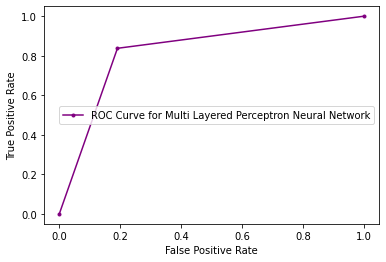

In [23]:
from sklearn.metrics import roc_curve
fp,tp,treshold = roc_curve(y_test,results)
plt.plot(fp,tp,marker = '.',label='ROC Curve for Multi Layered Perceptron Neural Network',color='purple')
plt.xlabel("False Positive Rate")
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()